In [1]:
import matplotlib
%matplotlib inline
import numpy as np
from nilearn import datasets
from nilearn import plotting
import nibabel as nib

from neurolang import frontend as fe

/Users/dwasserm/anaconda/envs/new3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/dwasserm/sources/NeuroLang/neurolang/expression_pattern_matching.py:54: UserWarning: Warning in class FirstOrderLogicSolver overwrites {'universal_predicate', 'existential_predicate'} from base GenericSolver[typing.Any]
  warn(warn_message)
/Users/dwasserm/anaconda/envs/new3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Example of how to translate the sulci file

`blender_obj_to_gifti -i 102311_L.obj -r 102311.L.pial.32k_fs_LR.surf.gii -o 102311.L.manual_drawings.func.gii`

In [2]:
destrieux_dataset = datasets.fetch_atlas_destrieux_2009()
destrieux_map = nib.load(destrieux_dataset['maps'])
destrieux_dataset['labels']

/Users/dwasserm/anaconda/envs/new3.6/lib/python3.6/site-packages/numpy/lib/npyio.py:2278: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


rec.array([(  0, b'Background'), (  1, b'L G_and_S_frontomargin'),
           (  2, b'L G_and_S_occipital_inf'),
           (  3, b'L G_and_S_paracentral'),
           (  4, b'L G_and_S_subcentral'),
           (  5, b'L G_and_S_transv_frontopol'),
           (  6, b'L G_and_S_cingul-Ant'),
           (  7, b'L G_and_S_cingul-Mid-Ant'),
           (  8, b'L G_and_S_cingul-Mid-Post'),
           (  9, b'L G_cingul-Post-dorsal'),
           ( 10, b'L G_cingul-Post-ventral'), ( 11, b'L G_cuneus'),
           ( 12, b'L G_front_inf-Opercular'),
           ( 13, b'L G_front_inf-Orbital'),
           ( 14, b'L G_front_inf-Triangul'), ( 15, b'L G_front_middle'),
           ( 16, b'L G_front_sup'), ( 17, b'L G_Ins_lg_and_S_cent_ins'),
           ( 18, b'L G_insular_short'), ( 19, b'L G_occipital_middle'),
           ( 20, b'L G_occipital_sup'), ( 21, b'L G_oc-temp_lat-fusifor'),
           ( 22, b'L G_oc-temp_med-Lingual'),
           ( 23, b'L G_oc-temp_med-Parahip'), ( 24, b'L G_orbital'),
  

In [6]:
surface = nib.load('102311.L.pial.32k_fs_LR.surf.gii')
vertices = surface.darrays[0].data
manual_sulci_gii = nib.load('102311.L.manual_drawings.func.gii')
manual_sulci = dict()
for darray in manual_sulci_gii.darrays:
    name = darray.meta.metadata['Name']
    name = name[:name.rfind('_')]
    points = vertices[darray.data.nonzero()]
    manual_sulci[name] = points
    print(f"{name}: number of points {points.shape[0]}")

Superior_temporal_sulcus: number of points 713
Superior_rostral_sulcus: number of points 132
Superior_occipital_sulcus: number of points 356
Superior_frontal_sulcus: number of points 807
Subparietal_sulcus: number of points 323
Rhinal_sulcus: number of points 79
Precentral_sulcus: number of points 570
Posterior_subcentral_sulcus: number of points 22
Postcentral_sulcus: number of points 683
Parieto_occipital_sulcus: number of points 247
Paracentral_sulcus: number of points 87
Olfactory_sulcus: number of points 138
Occipitotemporal_sulcus: number of points 289
Middle_frontal_sulcus: number of points 175
Medial_frontal_sulcus: number of points 553
Marginal_sulcus: number of points 166
Lunate_sulcus: number of points 94
Lateral_occipital_sulcus: number of points 210
Intraparietal_sulcus: number of points 562
Intralingual_sulcus: number of points 79
Inferior_temporal_sulcus: number of points 717
Inferior_occipital_sulcus: number of points 72
Inferior_frontal_sulcus: number of points 364
Hip

In [7]:
nl = fe.RegionFrontend()
for label_number, name in destrieux_dataset['labels']:
    name = name.decode()
    if not name.startswith('L ') or ('S_' not in name and 'Lat_Fis' not in name and 'Pole' not in name) or ('G_' in name) or ('circular' in name):
        continue

    # Create a region object
    region = nl.create_region(destrieux_map, label=label_number)

    # Fine tune the symbol name
    name = 'L_' + name[2:].replace('-', '_')
    nl.add_region(region, result_symbol_name=name)
    
for name, points in manual_sulci.items():
    ijk_points = nib.affines.apply_affine(np.linalg.inv(destrieux_map.affine), points).astype(int)
    region = fe.ExplicitVBR(
        ijk_points,
        destrieux_map.affine,
        img_dim=destrieux_map.shape
    )
    nl.add_region(region, result_symbol_name=f'manual_{name}')

# Primary sulci


In [8]:
central_sulcus = nl.symbols['manual_Central_sulcus']
plotting.view_img(
    central_sulcus.value.spatial_image(), title=central_sulcus.symbol_name,
    symmetric_map=False
)

/Users/dwasserm/anaconda/envs/new3.6/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/dwasserm/anaconda/envs/new3.6/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


primary_sulci: typing.AbstractSet[neurolang.regions.Region] = ['L_Lat_Fis_ant_Horizont', 'L_Pole_temporal', 'L_S_parieto_occipital', 'L_Lat_Fis_post', 'L_S_calcarine', 'L_S_central', 'L_S_pericallosal', 'L_Lat_Fis_ant_Vertical', 'L_Pole_occipital']


/Users/dwasserm/anaconda/envs/new3.6/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


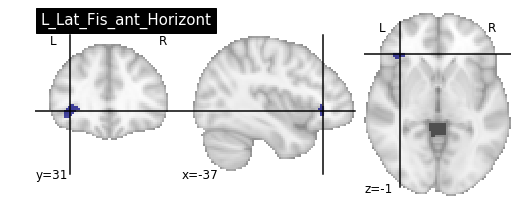

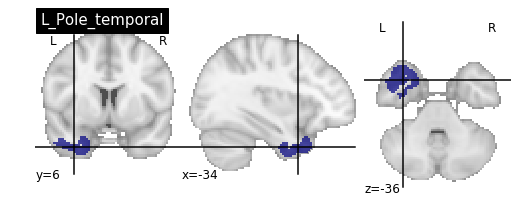

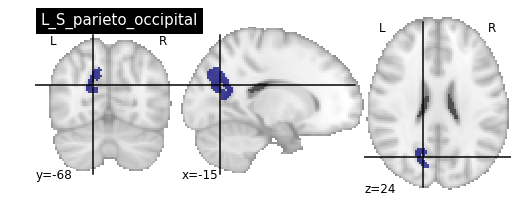

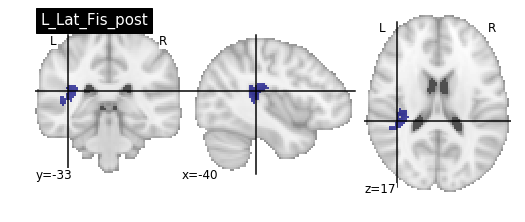

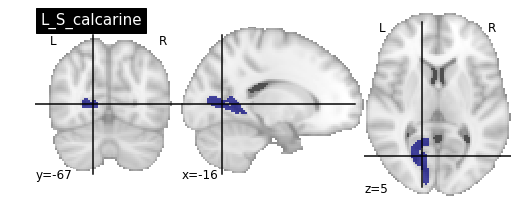

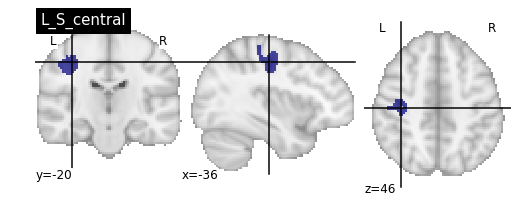

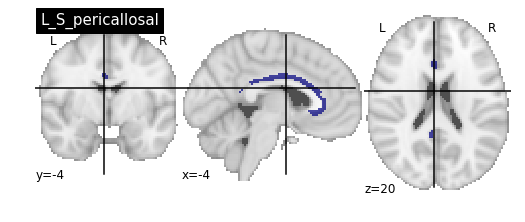

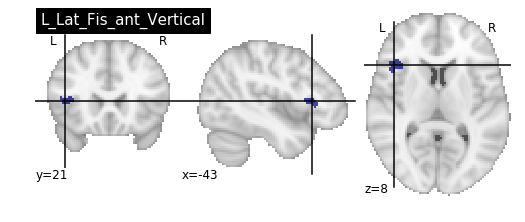

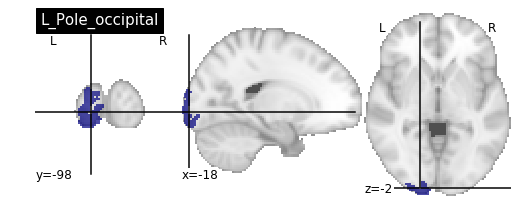

In [6]:
Primary_sulci= set()
for name in nl.region_names:
    if 'Lat_Fis' in name or 'parieto_occipital' in name or 'Pole' in name or 'S_central' in name or 'S_calcarine' in name or 'pericallosal' in name:
        Primary_sulci.add(nl.symbols[name])
        
primary_sulci = nl.add_region_set(Primary_sulci, name='primary_sulci')
print(primary_sulci)
for sulcus in primary_sulci:
    plotting.plot_roi(sulcus.value.spatial_image(), title=sulcus.symbol_name)

# Secondary sulci


In [7]:
Secondary_sulci=set()
secondary_sulci = nl.add_region_set(Secondary_sulci, name='secondary_sulci')

## Transverse Temporal sulcus

In [9]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_inferior_of(x, nl.symbols.L_Lat_Fis_post) &
        nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_parieto_occipital) &
        nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_collat_transv_ant) &
        nl.symbols.anatomical_posterior_of(x, nl.symbols.L_Pole_temporal) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci)
    )
)

res = q.do()

print("Looking for the Transverse Temporal Sulcus")

if len(res) != 1:
    print("More than one sulcus or no sulcus found")
else:
    print("Found")
    nl_tts = next(s for s in res)
    Secondary_sulci.add(nl_tts)
    plotting.plot_roi(nl_tts.value.spatial_image(), title=nl_tts.symbol_name)

Looking for the Transverse Temporal Sulcus
More than one sulcus or no sulcus found
479e2fee-f70b-11e8-99f1-8c85902183dd: typing.AbstractSet[neurolang.regions.Region] = ['manual_Hippocampal_fissure_NurbsPath.037', 'L_S_temporal_transverse']


## Lateral Occipitotemporal sulcus

Looking for the Occipitotemporal Sulcus
Found


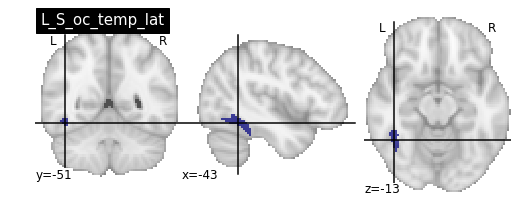

In [7]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_inferior_of(x, nl.symbols.L_Lat_Fis_ant_Horizont) &
        nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_calcarine) &
        nl.symbols.anatomical_superior_of(x, nl.symbols.L_Pole_temporal) &
        nl.symbols.anatomical_posterior_of(x, nl.symbols.L_Lat_Fis_post) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci)
    )
)
res = q.do()
print("Looking for the Occipitotemporal Sulcus")

if len(res) != 1:
    print("More than one sulcus or no sulcus found")
else:
    print("Found")
    nl_ots = next(s for s in res)
    Secondary_sulci.add(nl_ots)
    plotting.plot_roi(nl_ots.value.spatial_image(), title=nl_ots.symbol_name)

## Collateral sulcus: anterior part

Looking for the Collateral Sulcus (anterior part)
Found


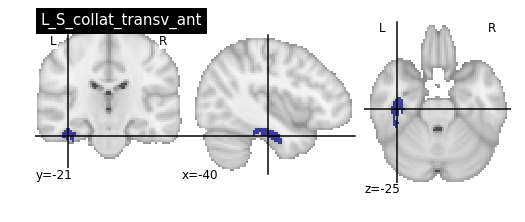

In [8]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_posterior_of(x, nl.symbols.L_Pole_temporal) &
        nl.symbols.anatomical_anterior_of(x, nl.symbols.L_Lat_Fis_post) &
        nl.symbols.anatomical_inferior_of(x, nl.symbols.L_Lat_Fis_ant_Horizont) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci)
    )
)
res = q.do()
print("Looking for the Collateral Sulcus (anterior part)")

if len(res) != 1:
    print("More than one sulcus or no sulcus found")
else:
    print("Found")
    nl_collat_ant = next(s for s in res)
    Secondary_sulci.add(nl_collat_ant)
    plotting.plot_roi(nl_collat_ant.value.spatial_image(), title=nl_collat_ant.symbol_name)

## Intermediate Primus of Jensen


Looking for the Intermediate Primus of Jensen
Found


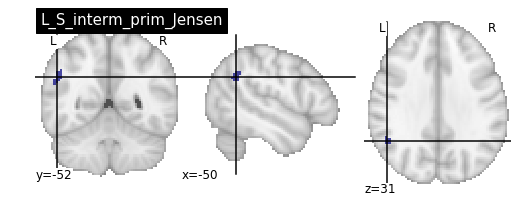

In [9]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_posterior_of(x, nl.symbols.L_S_central) &
        nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_pericallosal) &
        nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_parieto_occipital) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci)
    )
)
res = q.do()
print("Looking for the Intermediate Primus of Jensen")

if len(res) != 1:
    print("More than one sulcus or no sulcus found")
else:
    print("Found")
    nl_ipoj = next(s for s in res)
    Secondary_sulci.add(nl_ipoj)
    plotting.plot_roi(nl_ipoj.value.spatial_image(), title=nl_ipoj.symbol_name)

## Subparietal sulcus

Looking for the Subparietal Sulcus
Found


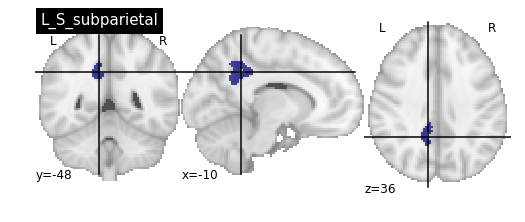

In [10]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_superior_of(x, nl.symbols.L_Lat_Fis_post) &
        nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_calcarine) &
        nl.symbols.anatomical_posterior_of(x, nl.symbols.L_S_central) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci)
    )
)
res = q.do()
print("Looking for the Subparietal Sulcus")

if len(res) != 1:
    print("More than one sulcus or no sulcus found")
else:
    print("Found")
    nl_subparietal = next(s for s in res)
    Secondary_sulci.add(nl_subparietal)
    plotting.plot_roi(nl_subparietal.value.spatial_image(), title=nl_subparietal.symbol_name)

Looking for the Subparietal Sulcus
Found


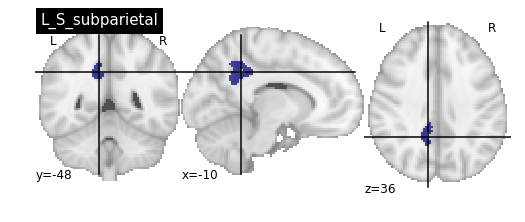

In [11]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_calcarine) &
        nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_calcarine) &
        nl.symbols.anatomical_posterior_of(x, nl.symbols.L_S_central) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci)
    )
)
res = q.do()
print("Looking for the Subparietal Sulcus")

if len(res)== 0:
    print("No sulcus found")
elif len(res)>1:
    print("More than one sulcus found")
else:
    print("Found")
    nl_subparietal = next(s for s in res)
    Secondary_sulci.add(nl_subparietal)
    plotting.plot_roi(nl_subparietal.value.spatial_image(), title=nl_subparietal.symbol_name)

## Looking for precentral superior and inferior parts

Looking for the Precentral Sulcus superior part
L_S_precentral_sup_part
Others found


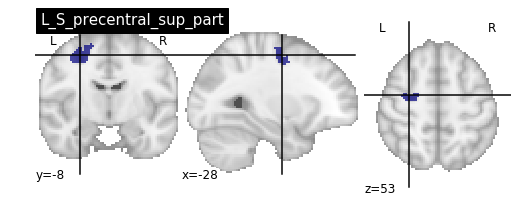

In [12]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_posterior_of(x, nl.symbols.L_Lat_Fis_ant_Horizont) &
        nl.symbols.anatomical_anterior_of(x, nl.symbols.L_Lat_Fis_post) &
        nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_pericallosal) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci)
    )
)
res = q.do()
print("Looking for the Precentral Sulcus superior part")

for r in res:
    if len(res)==0:
        print("No sulcus found")
    elif len(res)==1 and "precentral_sup" in r.symbol_name:
        print("Found Precentral superior part only")
        print(r.symbol_name)
        nl_precentral_sup = next(s for s in res)
        Secondary_sulci.add(nl_precentral_sup)
        plotting.plot_roi(nl_precentral_sup.value.spatial_image(), title=nl_precentral_sup.symbol_name)
    elif len(res)==2 and "precentral_sup" in r.symbol_name:
        print(r.symbol_name)
        nl_precentral_sup = next(s for s in res)
        Secondary_sulci.add(nl_precentral_sup)
        plotting.plot_roi(nl_precentral_sup.value.spatial_image(), title=nl_precentral_sup.symbol_name)
    else:
        print("Others found")

In [13]:
secondary_sulci = nl.add_region_set(Secondary_sulci, name='secondary_sulci')
print(secondary_sulci)
len(Secondary_sulci)


secondary_sulci: typing.AbstractSet[neurolang.regions.Region] = ['L_S_precentral_sup_part', 'L_S_oc_temp_lat', 'L_S_interm_prim_Jensen', 'L_S_subparietal', 'L_S_collat_transv_ant', 'L_S_temporal_transverse']


6

Looking for the Precentral Sulcus inferior part
Found Precentral inferior part only
L_S_precentral_inf_part


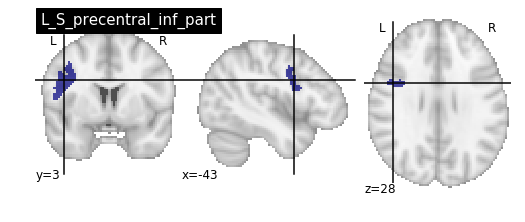

In [14]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_posterior_of(x, nl.symbols.L_Lat_Fis_ant_Horizont) &
        nl.symbols.anatomical_anterior_of(x, nl.symbols.L_Lat_Fis_post) &
        nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_pericallosal) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci)
    )
)
res = q.do()
print("Looking for the Precentral Sulcus inferior part")

for r in res:
    if len(res)==0:
        print("No sulcus found")
    elif len(res)==1 and "precentral_inf" in r.symbol_name:
        print("Found Precentral inferior part only")
        print(r.symbol_name)
        nl_precentral_inf = next(s for s in res)
        Secondary_sulci.add(nl_precentral_inf)
        plotting.plot_roi(nl_precentral_inf.value.spatial_image(), title=nl_precentral_inf.symbol_name)
    elif len(res)==2 and "precentral_inf" in r.symbol_name:
        print(r.symbol_name)
        nl_precentral_inf = next(s for s in res)
        Secondary_sulci.add(nl_precentral_inf)
        plotting.plot_roi(nl_precentral_inf.value.spatial_image(), title=nl_precentral_inf.symbol_name)
    else:
        print("Others found")
        print(r.symbol_name)

In [15]:
secondary_sulci = nl.add_region_set(Secondary_sulci, name='secondary_sulci')
print(secondary_sulci)
len(Secondary_sulci)


secondary_sulci: typing.AbstractSet[neurolang.regions.Region] = ['L_S_precentral_sup_part', 'L_S_oc_temp_lat', 'L_S_interm_prim_Jensen', 'L_S_subparietal', 'L_S_collat_transv_ant', 'L_S_temporal_transverse', 'L_S_precentral_inf_part']


7

# Tertiary sulci

In [16]:
Tertiary_sulci=set()
tertiary_sulci = nl.add_region_set(Tertiary_sulci, name='tertiary_sulci')

## Occipital superior and transversal sulci

Looking for the Superior Occipital and Transversal sulci
Found


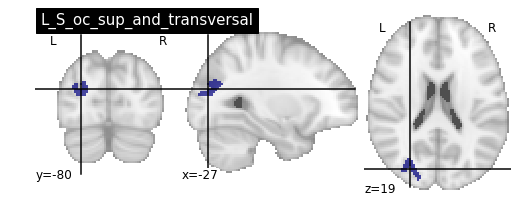

In [17]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_posterior_of(x, nl.symbols.L_Lat_Fis_post) &
        nl.symbols.anatomical_inferior_of(x, nl_subparietal) &
        nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_calcarine) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci) &
        ~nl.symbols.isin(x, tertiary_sulci)
    )
)
res = q.do()
print("Looking for the Superior Occipital and Transversal sulci")

if len(res)== 0:
    print("No sulcus found")
elif len(res)>1:
    print("More than one sulcus found")
else:
    print("Found")
    nl_oc_sup_trans = next(s for s in res)
    Tertiary_sulci.add(nl_oc_sup_trans)
    plotting.plot_roi(nl_oc_sup_trans.value.spatial_image(), title=nl_oc_sup_trans.symbol_name)

## Intraparietal sulcus

Looking for the Intraparietal Sulcus
Found


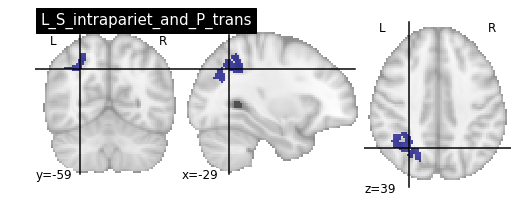

In [18]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_posterior_of(x, nl.symbols.L_S_pericallosal) &
        nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_calcarine) &
        nl.symbols.anatomical_anterior_of(x, nl.symbols.L_Pole_occipital) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci) &
        ~nl.symbols.isin(x, tertiary_sulci)
    )
)
res = q.do()
print("Looking for the Intraparietal Sulcus")

if len(res)== 0:
    print("No sulcus found")
elif len(res)>1:
    print("More than one sulcus found")
else:
    print("Found")
    nl_ips = next(s for s in res)
    Tertiary_sulci.add(nl_ips)
    plotting.plot_roi(nl_ips.value.spatial_image(), title=nl_ips.symbol_name)

Looking for the Intraparietal Sulcus
Found


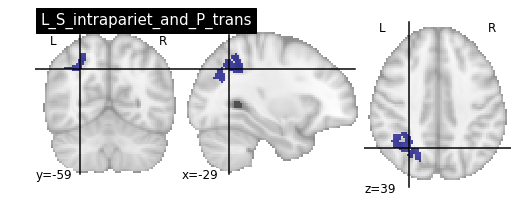

In [19]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_posterior_of(x, nl.symbols.L_S_pericallosal) &
        nl.symbols.anatomical_superior_of(x, nl.symbols.L_S_calcarine) &
        nl.symbols.anatomical_anterior_of(x, nl.symbols.L_Pole_occipital) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci)# &
#         ~nl.symbols.isin(x, tertiary_sulci)
    )
)
res = q.do()
print("Looking for the Intraparietal Sulcus")

if len(res)== 0:
    print("No sulcus found")
elif len(res)>1:
    print("More than one sulcus found")
else:
    print("Found")
    nl_ips = next(s for s in res)
    Tertiary_sulci.add(nl_ips)
    plotting.plot_roi(nl_ips.value.spatial_image(), title=nl_ips.symbol_name)

## Superior frontal sulcus

Looking for the Superior Frontal Sulcus
Found


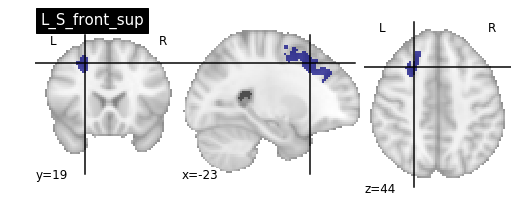

In [20]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_central) &
        nl.symbols.anatomical_superior_of(x, nl_ipoj) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci) &
        ~nl.symbols.isin(x, tertiary_sulci)
    )
)
res = q.do()
print("Looking for the Superior Frontal Sulcus")

if len(res)== 0:
    print("No sulcus found")
elif len(res)>1:
    print("More than one sulcus found")
else:
    print("Found")
    nl_sfs = next(s for s in res)
    Tertiary_sulci.add(nl_sfs)
    plotting.plot_roi(nl_sfs.value.spatial_image(), title=nl_sfs.symbol_name)

## Postcentral sulcus 

Looking for the Postcentral Sulcus
Found


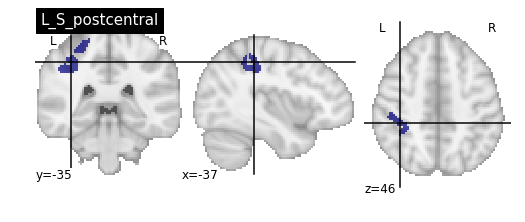

In [21]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_posterior_of(x, nl_precentral_sup) &
        nl.symbols.anatomical_superior_of(x, nl_subparietal) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci) &
        ~nl.symbols.isin(x, tertiary_sulci)
    )
)
res = q.do()
print("Looking for the Postcentral Sulcus")

if len(res)== 0:
    print("No sulcus found")
elif len(res)>1:
    print("More than one sulcus found")
else:
    print("Found")
    nl_pocs = next(s for s in res)
    Tertiary_sulci.add(nl_pocs)
    plotting.plot_roi(nl_pocs.value.spatial_image(), title=nl_pocs.symbol_name)

## Middle frontal sulcus

Looking for the Middle Frontal Sulcus
Found


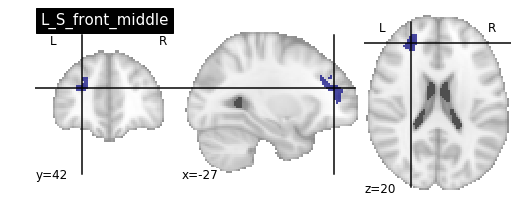

In [22]:
x = nl.new_region_symbol('x')
q = nl.query(
    x, 
    (
        nl.symbols.anatomical_anterior_of(x, nl_precentral_sup) &
        nl.symbols.anatomical_superior_of(x, nl.symbols.L_Lat_Fis_ant_Vertical) &
        nl.symbols.anatomical_inferior_of(x, nl_precentral_sup) &
        ~nl.symbols.isin(x, primary_sulci) &
        ~nl.symbols.isin(x, secondary_sulci) &
        ~nl.symbols.isin(x, tertiary_sulci)
    )
)
res = q.do()
print("Looking for the Middle Frontal Sulcus")

if len(res)== 0:
    print("No sulcus found")
elif len(res)>1:
    print("More than one sulcus found")
else:
    print("Found")
    nl_mfs = next(s for s in res)
    Tertiary_sulci.add(nl_mfs)
    plotting.plot_roi(nl_mfs.value.spatial_image(), title=nl_mfs.symbol_name)

In [23]:
tertiary_sulci = nl.add_region_set(Tertiary_sulci, name='tertiary_sulci')
print(tertiary_sulci)
print(len(tertiary_sulci))

tertiary_sulci: typing.AbstractSet[neurolang.regions.Region] = ['L_S_postcentral', 'L_S_oc_sup_and_transversal', 'L_S_front_sup', 'L_S_intrapariet_and_P_trans', 'L_S_front_middle']
5


In [24]:
x = nl.new_region_symbol('x')
temporal_lobe_query = nl.query(
    x,
    nl.symbols.anatomical_inferior_of(x, nl.symbols.L_S_parieto_occipital) &
    nl.symbols.anatomical_anterior_of(x, nl.symbols.L_S_calcarine) &
    nl.symbols.anatomical_posterior_of(x, nl.symbols.L_Lat_Fis_ant_Horizont)
)
temporal_lobe = q.do() #result_symbol_name='temporal_lobe')
print(temporal_lobe)

##################################################
#

#q = nl.query(
#    x,
  #  nl.symbols.isin(x, temporal_lobe) &
#    ~nl.symbols.anatomical_inferior_of(x, nl.symbols.l_s_temporal_inf)
#)

# print(q)

018c3b5b-f6e2-11e8-bed4-8cec4bd9aee6: typing.AbstractSet[neurolang.regions.Region] = ['L_S_front_middle']


In [25]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.
